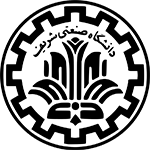

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
 Deep Learning <br>
<font color=2565AE size=5>
Electrical Engineering Department - Fall 2025  <br>
<font color=3C99D size=5>
          Homework 4<br>
<font color=696880 size=4>

**Name**:  Ali Amjadi
  
**Student ID**: 404205889

# **Variational Auto-Encoder (VAE)**

Variational Auto-Encoders (VAEs) are a widely used class of generative models. They are simple to implement and, in contrast to other generative model classes like Generative Adversarial Networks, they optimize an explicit maximum likelihood objective to train the model. Finally, their architecture makes them well-suited for unsupervised representation learning, i.e., learning low-dimensional representations of high-dimenionsal inputs, like images, with only self-supervised objectives (data reconstruction in the case of VAEs).

**By working on this problem you will learn and practice the following steps:**
1. Set up a data loading pipeline in PyTorch.
2. Implement, train and visualize an auto-encoder architecture.
3. Extend your implementation to a variational auto-encoder.
4. Learn how to tune the critical beta parameter of your VAE.
5. Inspect the learned representation of your VAE.
6. Extend VAE's generative capabilities by conditioning it on the label you wish to generate.



# 1. MNIST Dataset[5 pt]

We will perform all experiments for this problem using the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), a standard dataset of handwritten digits. The main benefits of this dataset are that it is small and relatively easy to model. It therefore allows for quick experimentation and serves as initial test bed in many papers.


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,2"

In [3]:
import torch
import torchvision
from torchvision import transforms

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   # use GPU if available
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# this will automatically download the MNIST training set
mnist_train =torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
print("\n Download complete! Downloaded {} training examples!".format(len(mnist_train)))

Using device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 52.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.79MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.15MB/s]


 Download complete! Downloaded 60000 training examples!


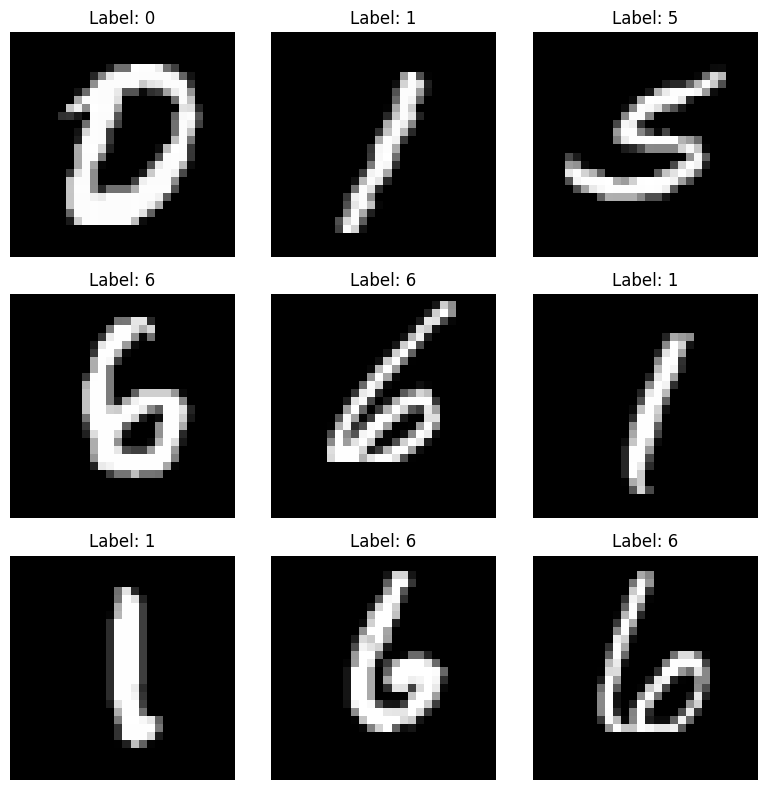

In [4]:
# Display some of the training samples.
import matplotlib.pyplot as plt

# Create a 3x3 grid for displaying 9 samples
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i in range(3):
    for j in range(3):
        # Get a random sample
        idx = torch.randint(0, len(mnist_train), (1,)).item()
        image, label = mnist_train[idx]
        
        # Display the image
        axes[i, j].imshow(image.squeeze(), cmap='gray')
        axes[i, j].set_title(f"Label: {label}")
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

# 2. Auto-Encoder[35 pt]

Before implementing the full VAE, we will first implement an **auto-encoder architecture**. Auto-encoders use an encoder–decoder architecture to learn low-dimensional representations of data without supervision. The encoder compresses the input image into a small latent vector using fully connected layers, and the decoder maps this vector back to the original image space. The model is trained by minimizing a reconstruction loss between the input and the reconstructed output. Because image pixels contain redundant information, the auto-encoder can learn a compact embedding that still preserves key features such as digit identity and shape. This compressed representation can make downstream tasks easier. In this assignment, you will define encoder and decoder networks and then train the auto-encoder.

Learning such a **compressed representation can make downstream task learning easier**. For example, learning to add two numbers based on the inferred digits is much easier than performing the task based on two piles of pixel values that depict the digits.

In the following, we will first define the architecture of encoder and decoder and then train the auto-encoder model.

## Defining the Auto-Encoder Architecture[10 pt]

In [5]:
import torch.nn as nn
class Encoder(nn.Module):
  def __init__(self, nz, input_size):
    super().__init__()
    self.input_size = input_size
    self.net = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(True),
            nn.Dropout(0.2),  # Add dropout
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(0.2),  # Add dropout
            nn.Linear(256, nz)
        )

  def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.net(x)


class Decoder(nn.Module):
  def __init__(self, nz, output_size):
    super().__init__()
    self.output_size = output_size
    # TODO
    self.net = nn.Sequential(
            nn.Linear(nz, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, output_size),
            nn.Sigmoid()  # Output values between 0 and 1
        )
  def forward(self, z):
    return self.net(z).view(-1, 1, 28, 28)


## Testing the Auto-Encoder Forward Pass[5 pt]

To verify that your auto-encoder is implemented correctly, you will create a DataLoader for sampling training batches and then run a forward pass through the encoder and decoder. This test ensures that your networks accept inputs of the expected shape and produce latent vectors and reconstructions with the correct dimensions.

In [6]:
batch_size = 64
nworkers = 2

mnist_data_loader = torch.utils.data.DataLoader(
    mnist_train,          # Dataset
    batch_size=batch_size,  # Batch size
    shuffle=True,         # Shuffle the data
    num_workers=nworkers  # Number of worker processes
)

in_size = out_size = 28*28
nz = 32
encoder = Encoder(nz=nz, input_size=in_size)
decoder = Decoder(nz=nz, output_size=out_size)

for sample_img, sample_label in mnist_data_loader:
    input = sample_img.reshape([batch_size, in_size])
    print(f'{sample_img.shape=}, {type(sample_img)}, {input.shape=}')
    enc = encoder(input)
    print(f"Shape of encoding vector (should be [batch_size, nz]): {enc.shape}")
    dec = decoder(enc)
    print("Shape of decoded image (should be [batch_size, 1, out_size]): {}.".format(dec.shape))
    break


sample_img.shape=torch.Size([64, 1, 28, 28]), <class 'torch.Tensor'>, input.shape=torch.Size([64, 784])
Shape of encoding vector (should be [batch_size, nz]): torch.Size([64, 32])
Shape of decoded image (should be [batch_size, 1, out_size]): torch.Size([64, 1, 28, 28]).


Now that we defined encoder and decoder network our architecture is nearly complete. However, before we start training, we can wrap encoder and decoder into an auto-encoder class for easier handling.

In [7]:
class AutoEncoder(nn.Module):
  def __init__(self, nz):
    super().__init__()
    in_size = out_size = 28 * 28
    self.encoder = Encoder(nz=nz, input_size=in_size)
    self.decoder = Decoder(nz=nz, output_size=out_size)

  def forward(self, x):
    x_flat = x.view(x.size(0), -1)
    return self.decoder(self.encoder(x_flat))

  def reconstruct(self, x):
    """Only used later for visualization."""
    image = self.forward(x).view(-1, 1, 28, 28)
    return image

## Setting up the Auto-Encoder Training Loop[5 pt]
After implementing the network architecture, we can now set up the training loop and run training.

In [ ]:
epochs = 10
learning_rate = 1e-3

print(f'Device available {device}')
ae_model = AutoEncoder(nz).to(device)
ae_model = ae_model.train()

# build optimizer and loss function
optimizer = torch.optim.Adam(ae_model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

train_it = 0
for ep in range(epochs):
    print("Run Epoch {}".format(ep))
    for data, _ in mnist_data_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        reconstructed = ae_model(data)
        rec_loss = criterion(reconstructed, data)
        
        rec_loss.backward()
        optimizer.step()
        
        train_it += 1

print("Done!")
del epochs, learning_rate, data, train_it, rec_loss


Device available cpu
Run Epoch 0
Run Epoch 1
Run Epoch 2
Run Epoch 3
Run Epoch 4
Run Epoch 5


## Verifying reconstructions[5 pt]
Now that we trained the auto-encoder we can visualize some of the reconstructions on the test set to verify that it is converged and did not overfit. **Before continuing, make sure that your auto-encoder is able to reconstruct these samples near-perfectly.**

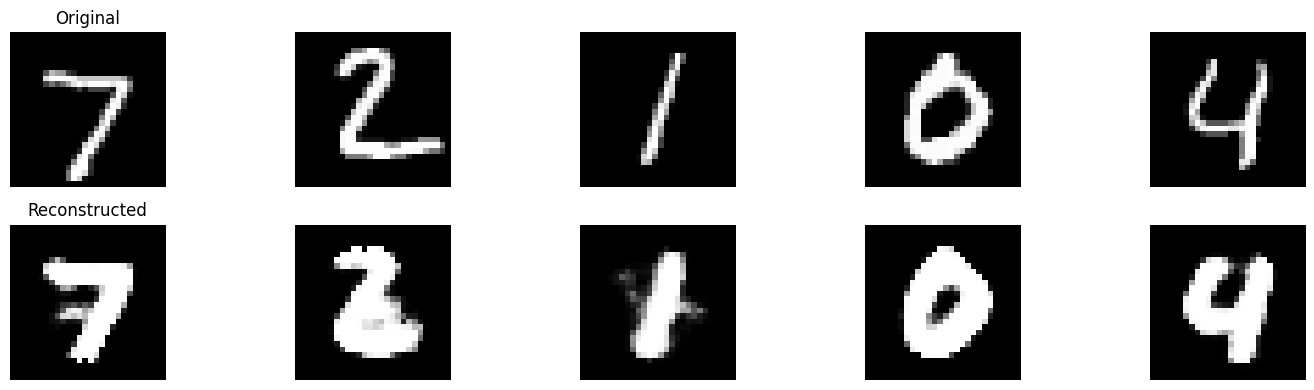

In [10]:
def vis_reconstruction(model, randomize=False):
    mnist_test = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )
    # TODO
    model.eval()
    fig, axes = plt.subplots(2, 5, figsize=(15, 4))
    with torch.no_grad():
        for i in range(5):
            # Get index
            idx = torch.randint(0, len(mnist_test), (1,)).item() if randomize else i
            
            # Get and process image
            image, _ = mnist_test[idx]
            image_tensor = image.unsqueeze(0).to(device)
            reconstruction = model.reconstruct(image_tensor)
            
            # Display original
            axes[0, i].imshow(image.squeeze(), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title("Original")
            
            # Display reconstruction
            axes[1, i].imshow(reconstruction.squeeze().cpu(), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title("Reconstructed")
    
    plt.tight_layout()
    plt.show()

vis_reconstruction(ae_model, randomize=False)


## Sampling from the Auto-Encoder[5 pt]

To test whether the auto-encoder is useful as a generative model, we can use it like any other generative model: draw embedding samples from a prior distribution and decode them through the decoder network. We will choose a unit Gaussian prior to allow for easy comparison to the VAE later.

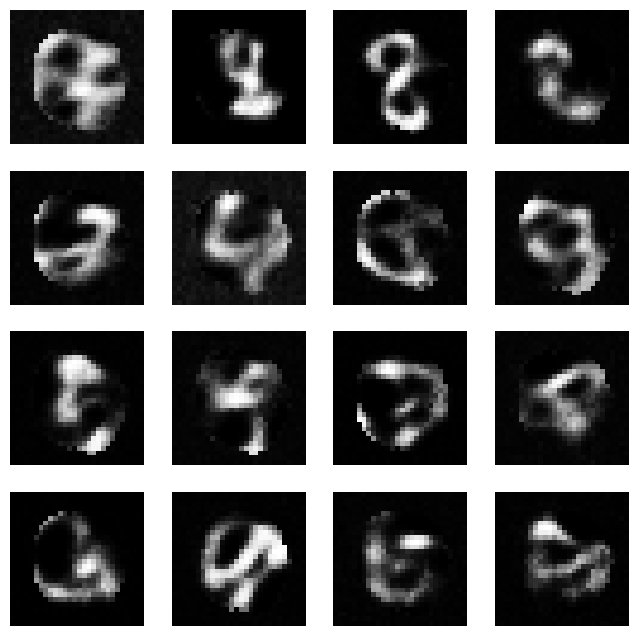

In [11]:
# we will sample N embeddings, then decode and visualize them
def vis_samples(model):
    model.eval()
    
    n_samples = 16
    with torch.no_grad():
        z = torch.randn(n_samples, nz).to(device)
        generated = model.decoder(z).view(-1, 1, 28, 28).cpu()
    
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(16):
        axes[i//4, i%4].imshow(generated[i].squeeze(), cmap='gray')
        axes[i//4, i%4].axis('off')
    
    plt.show()


vis_samples(ae_model)


>**Inline Question: Describe your observations, why do you think they occur? [5 pt]**



The distribution in the latent space is completely random and has not meaning what so ever! This shows we have been mapping the input to som specific areas of the latent space dimansion space and not every point in this space will produce a meaningful output.

# 3. Variational Auto-Encoder (VAE)[35 pt]

Variational auto-encoders use a very similar architecture to deterministic auto-encoders, but are inherently storchastic models, i.e. we perform a stochastic sampling operation during the forward pass, leading to different different outputs every time we run the network for the same input. This sampling is required to optimize the VAE objective also known as the evidence lower bound (ELBO):

$$
p(x) > \underbrace{\mathbb{E}_{z\sim q(z\vert x)} p(x \vert z)}_{\text{reconstruction}} - \underbrace{D_{\text{KL}}\big(q(z \vert x), p(z)\big)}_{\text{prior divergence}}
$$


For simplicity, we will choose a unit Gaussian prior again. The first term is the reconstruction term we already know from training the auto-encoder. When assuming a Gaussian output distribution for both encoder $q(z \vert x)$ and decoder $p(x \vert z)$ the objective reduces to:

$$
\mathcal{L}_{\text{VAE}} = \sum_{x\sim \mathcal{D}} \mathcal{L}_{\text{rec}}(x, \hat{x}) - \beta \cdot D_{\text{KL}}\big(\mathcal{N}(\mu_q, \sigma_q), \mathcal{N}(0, I)\big)
$$


The coefficient $\beta$ is a scalar weighting factor that trades off between reconstruction and regularization objective. We will investigate the influence of this factor in out experiments below.


### Reparametrization Trick

The sampling procedure inside the VAE's forward pass for obtaining a sample $z$ from the posterior distribution $q(z \vert x)$, when implemented naively, is non-differentiable. However, since $q(z\vert x)$ is parametrized with a Gaussian function, there is a simple trick to obtain a differentiable sampling operator, known as the _reparametrization trick_.

Instead of directly sampling $z \sim \mathcal{N}(\mu_q, \sigma_q)$ we can "separate" the network's predictions and the random sampling by computing the sample as:

$$
z = \mu_q + \sigma_q * \epsilon , \quad \epsilon \sim \mathcal{N}(0, I)
$$

Note that in this equation, the sample $z$ is computed as a deterministic function of the network's predictions $\mu_q$ and $\sigma_q$ and therefore allows to propagate gradients through the sampling procedure.

**Note**: While in the equations above the encoder network parametrizes the standard deviation $\sigma_q$ of the Gaussian posterior distribution, in practice we usually parametrize the **logarithm of the standard deviation** $\log \sigma_q$ for numerical stability. Before sampling $z$ we will then exponentiate the network's output to obtain $\sigma_q$.



## Defining the VAE Model [15 pt]

In [ ]:
def kl_divergence(mu1, log_sigma1, mu2, log_sigma2):
  #TODO

class VAE(nn.Module):
  def __init__(self, nz, beta=1.0):
    super().__init__()
    self.beta = beta
    # TODO

  def forward(self, x):
    # TODO
    return {'q': q,
            'rec': reconstruction}

  def loss(self, x, outputs):
    # TODO
    return rec_loss + self.beta * kl_loss, {'rec_loss': rec_loss, 'kl_loss': kl_loss}

  def reconstruct(self, x):
    """Use mean of posterior estimate for visualization reconstruction."""
    # TODO
    return image


## Setting up the VAE Training Loop [5 pt]

Let's start training the VAE model! We will first verify our implementation by setting $\beta = 0$.


In [ ]:
# TODO
learning_rate =
nz =
beta =
epochs =
optimizer =

vae_model = VAE(nz, beta).to(device)
vae_model = vae_model.train()



train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")
for ep in range(epochs):
    print("Run Epoch {}".format(ep))
    #TODO

print("Done!")

rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

# log the loss training curves
# TODO


Let's look at some reconstructions and decoded embedding samples!

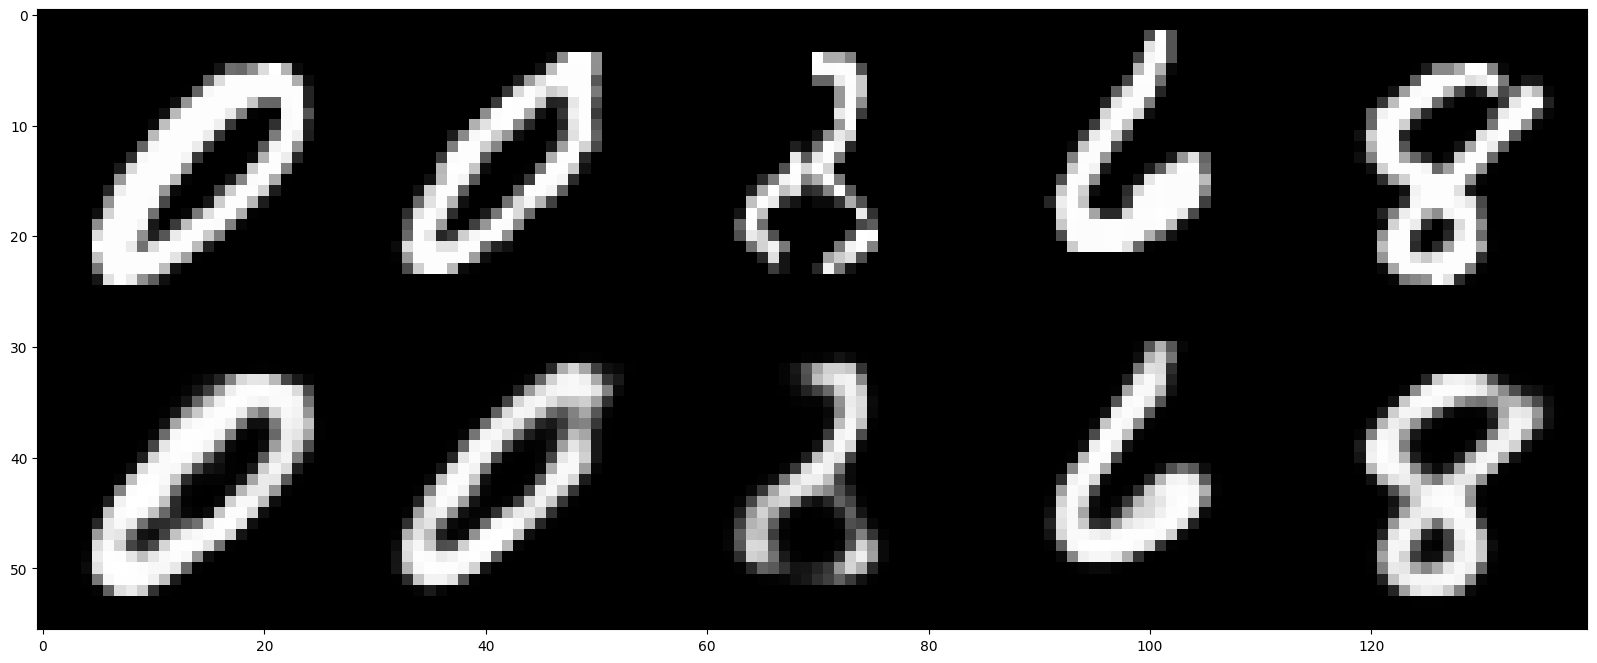

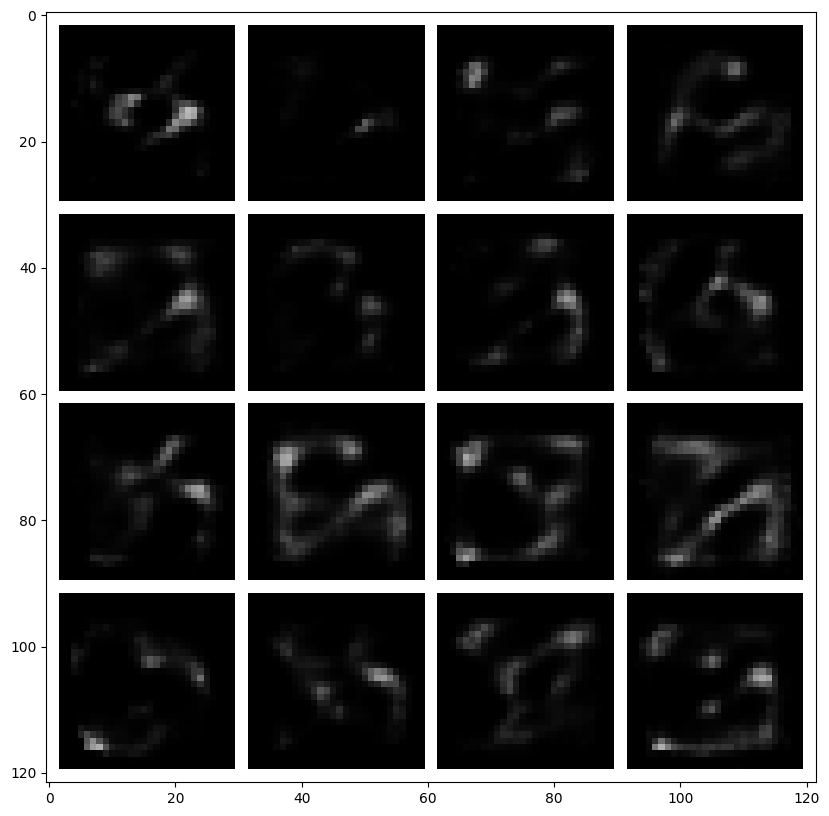

In [ ]:
vis_reconstruction(vae_model, randomize=True)
vis_samples(vae_model)

## Tweaking the loss function $\beta$ [2 pt]
Prob1-6: Let's repeat the same experiment for $\beta = 10$, a very high value for the coefficient.

Running 10 epochs with beta=10
Run Epoch 0
It 0: Total Loss: 0.755879819393158, 	 Rec Loss: 0.6967155337333679,	 KL Loss: 0.005916427820920944
It 100: Total Loss: 0.2703720033168793, 	 Rec Loss: 0.2699931263923645,	 KL Loss: 3.7886755308136344e-05
It 200: Total Loss: 0.2656492590904236, 	 Rec Loss: 0.2653822600841522,	 KL Loss: 2.670101821422577e-05
It 300: Total Loss: 0.2645787298679352, 	 Rec Loss: 0.26445627212524414,	 KL Loss: 1.2245451216585934e-05
It 400: Total Loss: 0.26688411831855774, 	 Rec Loss: 0.26678648591041565,	 KL Loss: 9.76190494839102e-06
It 500: Total Loss: 0.25960278511047363, 	 Rec Loss: 0.25953277945518494,	 KL Loss: 7.000868208706379e-06
It 600: Total Loss: 0.25034552812576294, 	 Rec Loss: 0.2502621114253998,	 KL Loss: 8.34079401101917e-06
It 700: Total Loss: 0.25414803624153137, 	 Rec Loss: 0.25408443808555603,	 KL Loss: 6.360409315675497e-06
It 800: Total Loss: 0.27138176560401917, 	 Rec Loss: 0.2713301181793213,	 KL Loss: 5.165566108189523e-06
It 900: Total Lo

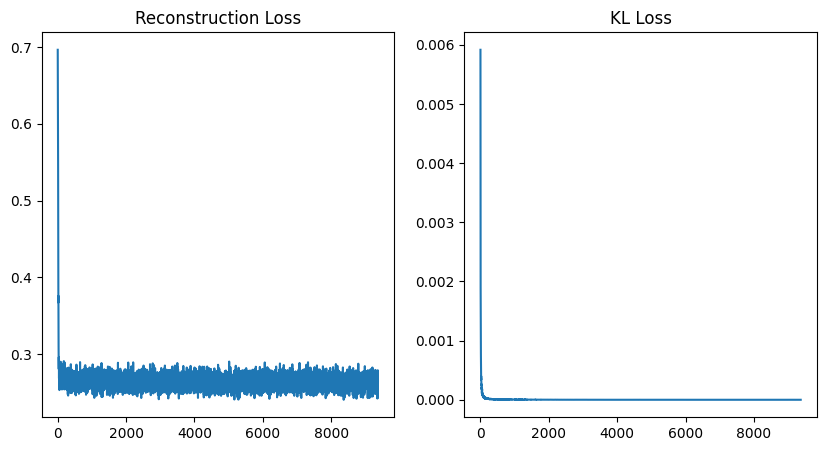

In [ ]:
# TODO

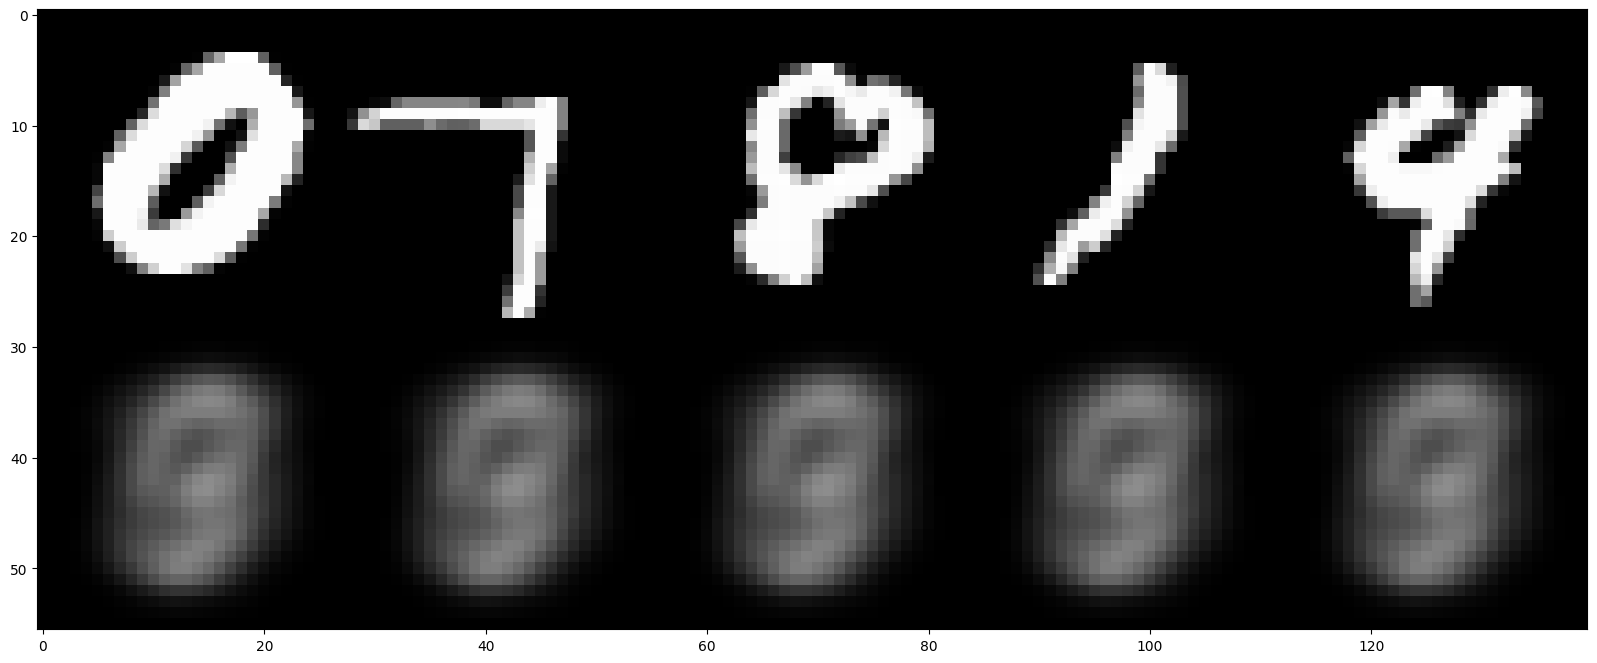

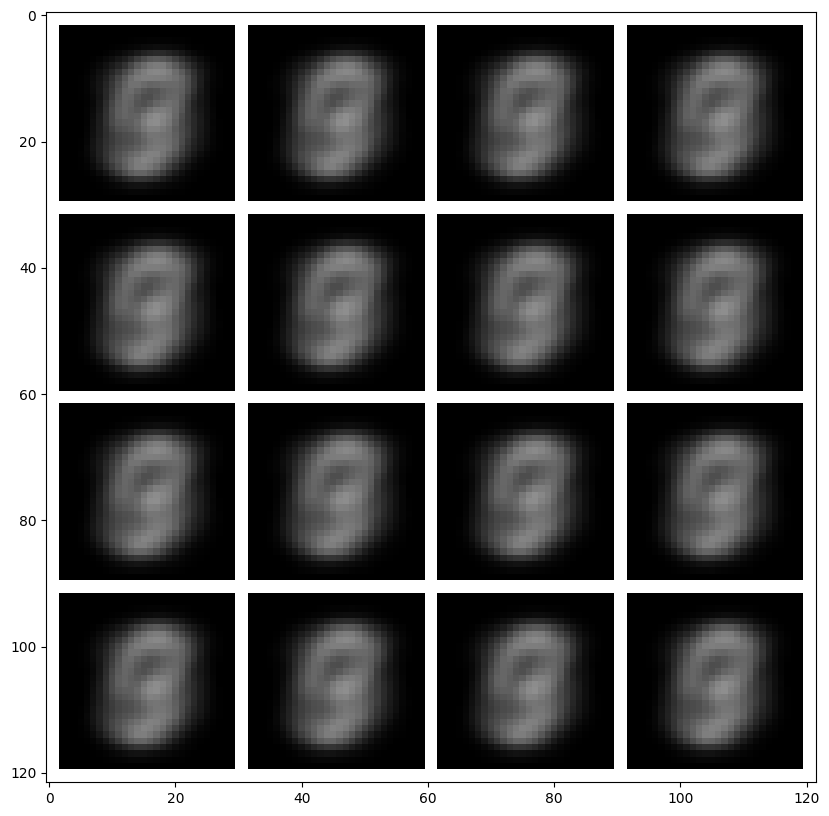

In [ ]:
vis_reconstruction(vae_model, randomize=True)
vis_samples(vae_model)

>**Inline Question: What can you observe when setting $\beta = 0$ and $\beta = 10$? Explain your observations! [3 pt]**


## Obtaining the best $\beta$-factor[7 pt]
Prob 1-6 continued: Now we can start tuning the beta value to achieve a good result. First describe what a "good result" would look like (focus what you would expect for reconstructions and sample quality).

>**Inline Question: Characterize what properties you would expect for reconstructions and samples of a well-tuned VAE! [3pt]**


Now that you know what outcome we would like to obtain, try to tune $\beta$ to achieve this result. Logarithmic search in steps of 10x will be helpful, good results can be achieved after ~20 epochs of training. Training reconstructions should be high quality, test samples should be diverse, distinguishable numbers, most samples recognizable as numbers.


Running 10 epochs with beta=0.135
Run Epoch 0
It 0: Total Loss: 0.6997756361961365, 	 Rec Loss: 0.6990616321563721,	 KL Loss: 0.005288729444146156
It 100: Total Loss: 0.2689500153064728, 	 Rec Loss: 0.26548826694488525,	 KL Loss: 0.025642510503530502
It 200: Total Loss: 0.2516728937625885, 	 Rec Loss: 0.2476845532655716,	 KL Loss: 0.029543321579694748
It 300: Total Loss: 0.2466597855091095, 	 Rec Loss: 0.24019783735275269,	 KL Loss: 0.0478663370013237
It 400: Total Loss: 0.23544864356517792, 	 Rec Loss: 0.2243788093328476,	 KL Loss: 0.08199872076511383
It 500: Total Loss: 0.24289606511592865, 	 Rec Loss: 0.23148900270462036,	 KL Loss: 0.08449673652648926
It 600: Total Loss: 0.22534829378128052, 	 Rec Loss: 0.2089937925338745,	 KL Loss: 0.12114448845386505
It 700: Total Loss: 0.23907221853733063, 	 Rec Loss: 0.22027741372585297,	 KL Loss: 0.13922074437141418
It 800: Total Loss: 0.22563879191875458, 	 Rec Loss: 0.20657116174697876,	 KL Loss: 0.1412416696548462
It 900: Total Loss: 0.21831

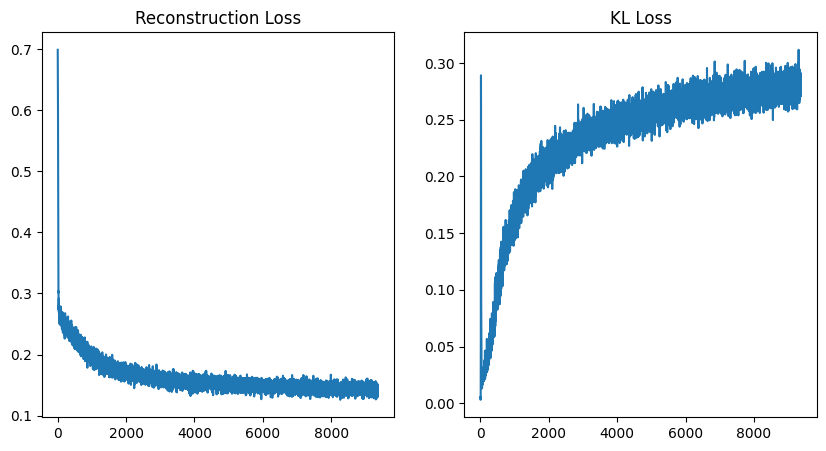

In [ ]:
# Tuning for best beta
# TODO

BEST beta =  0.135


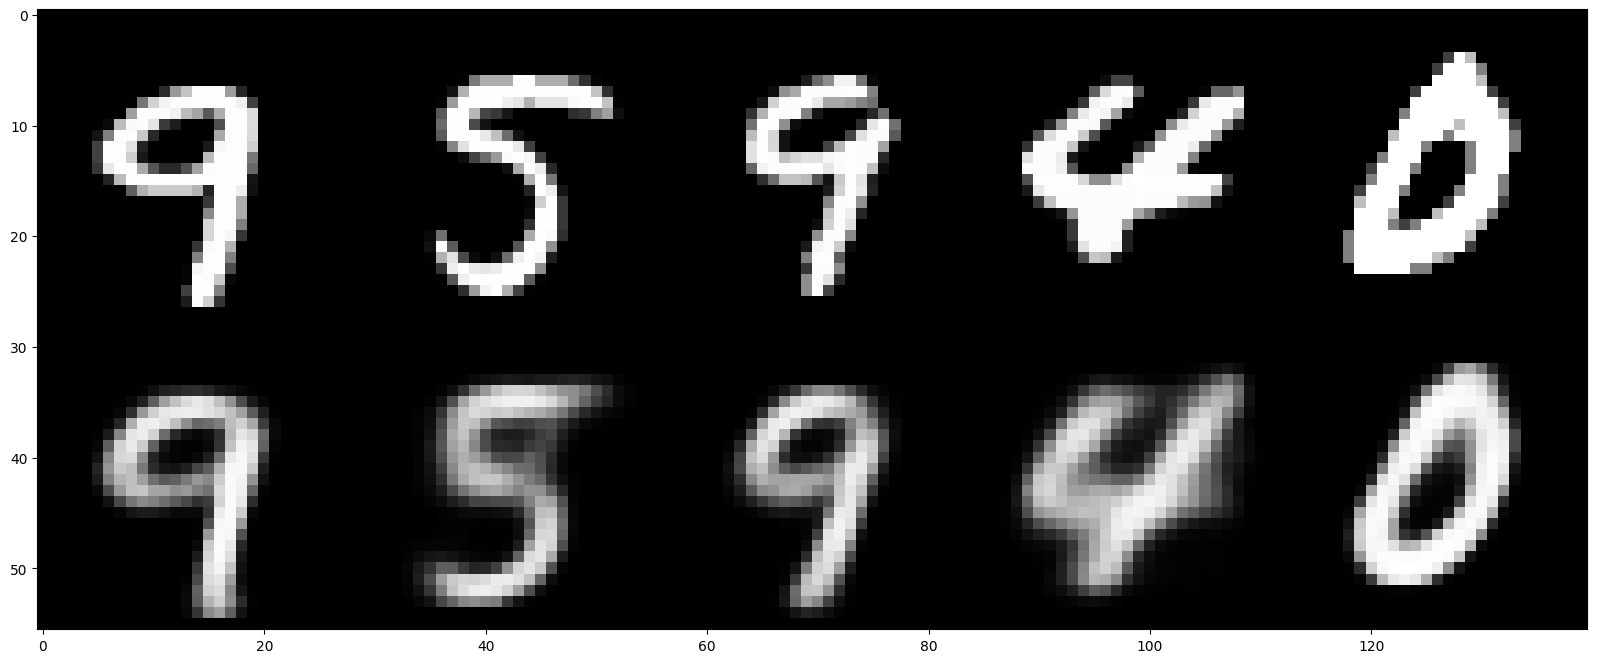

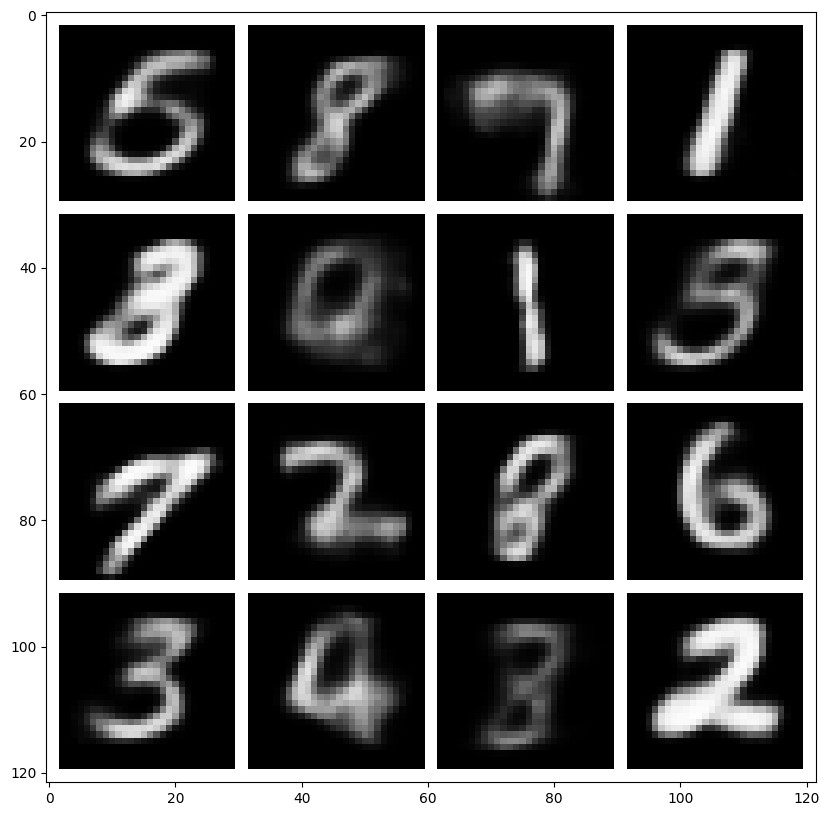

In [ ]:
print("BEST beta = ", beta)
vis_reconstruction(vae_model, randomize=True)
vis_samples(vae_model)

# 4. Embedding Space Interpolation[8 pt]

As mentioned in the introduction, AEs and VAEs cannot only be used to generate images, but also to learn low-dimensional representations of their inputs. In this final section we will investigate the representations we learned with both models by **interpolating in embedding space** between different images. We will encode two images into their low-dimensional embedding representations, then interpolate these embeddings and reconstruct the result.

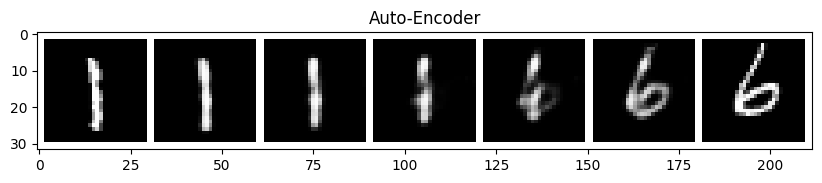

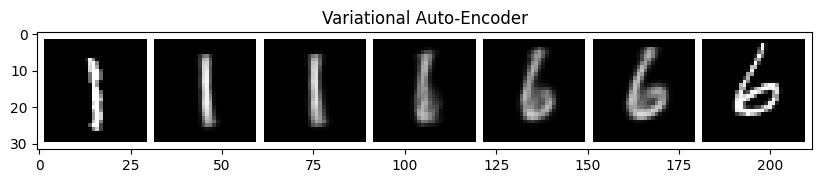

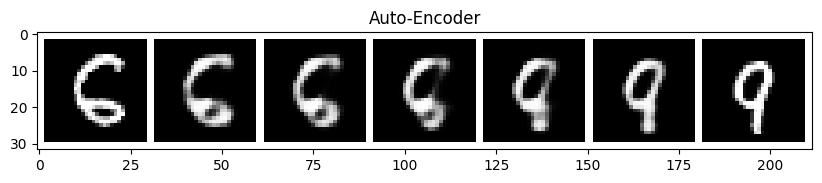

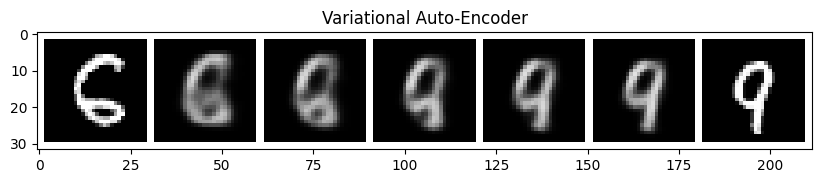

In [ ]:
nz=32

def get_image_with_label(target_label):
  """Returns a random image from the training set with the requested digit."""
  # TODO
        return img.to(device)

def interpolate_and_visualize(model, tag, start_img, end_img):
  """Encodes images and performs interpolation. Displays decodings."""
  model.eval()
  # TODO
  plt.show()


### Interpolation 1
# TODO
START_LABEL =
END_LABEL =
# sample two training images with given labels
start_img =
end_img =
# visualize interpolations for AE and VAE models
# TODO

### Interpolation 2
# TODO
START_LABEL =
END_LABEL =
# sample two training images with given labels
start_img =
end_img =
# visualize interpolations for AE and VAE models
# TODO


Repeat the experiment for different start / end labels and different samples. Describe your observations.

>**Inline Question: Repeat the interpolation experiment with different start / end labels and multiple samples. Describe your observations! [5 pt]**
>  1. How do AE and VAE embedding space interpolations differ?
>  2. How do you expect these differences to affect the usefulness of the learned representation for downstream learning?


# 5. Conditional VAE[10 pt]
Let us now try a Conditional VAE
Now we will try to create a [Conditional VAE](https://proceedings.neurips.cc/paper/2014/file/d523773c6b194f37b938d340d5d02232-Paper.pdf), where we can condition the encoder and decoder of the VAE on the label `c`.

## Defining the conditional Encoder, Decoder, and VAE models [7 pt]

Prob1-8. We create a separate encoder and decoder class that take in an additional argument `c` in their forward pass, and then build our CVAE model on top of it. Note that the encoder and decoder just need to append `c` to the standard inputs to these modules.

In [ ]:
def idx2onehot(idx, n):
    """Converts a batch of indices to a one-hot representation."""
    # TODO
    return onehot

# Define encoder and decoder networks

class CVAEEncoder(nn.Module):
  def __init__(self, nz, input_size, conditional, num_labels):
    super().__init__()
    self.input_size = input_size + num_labels if conditional else input_size
    self.num_labels = num_labels
    self.conditional = conditional
    # Create the network architecture using a nn.Sequential module wrapper.
    # TODO

  def forward(self, x, c=None):
    # TODO
    return self.net(x)


class CVAEDecoder(nn.Module):
  def __init__(self, nz, output_size, conditional, num_labels):
    super().__init__()
    self.output_size = output_size
    self.conditional = conditional
    self.num_labels = num_labels
    if self.conditional:
        nz = nz + num_labels
    # Create the network architecture using a nn.Sequential module wrapper.
    # TODO


  def forward(self, z, c=None):
    # TODO
    return self.net(z).reshape(-1, 1, self.output_size)


class CVAE(nn.Module):
    def __init__(self, nz, beta=1.0, conditional=False, num_labels=0):
        super().__init__()
        if conditional:
            assert num_labels > 0
        self.beta = beta
        # TODO
        self.encoder =
        self.decoder =

    def forward(self, x, c=None):
        # TODO
        return {'q': q, 'rec': reconstruction, 'c': c}

    def loss(self, x, outputs):
        # TODO
        return rec_loss + self.beta * kl_loss, \
            {'rec_loss': rec_loss, 'kl_loss': kl_loss}

    def reconstruct(self, x, c=None):
        # TODO
        return image

## Setting up the CVAE Training loop[2 pt]

In [ ]:
# TODO
learning_rate =
nz =
epochs =
beta =
conditional =
cvae_model =
cvae_model =
optimizer =

train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")
for ep in range(epochs):
    print(f"Run Epoch {ep}")
    # TODO
print("Done!")

rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

# log the loss training curves
# TODO


### Verifying conditional samples from CVAE[1 pt]
Now let us generate samples from the trained model, conditioned on all the labels.

<Figure size 640x480 with 0 Axes>

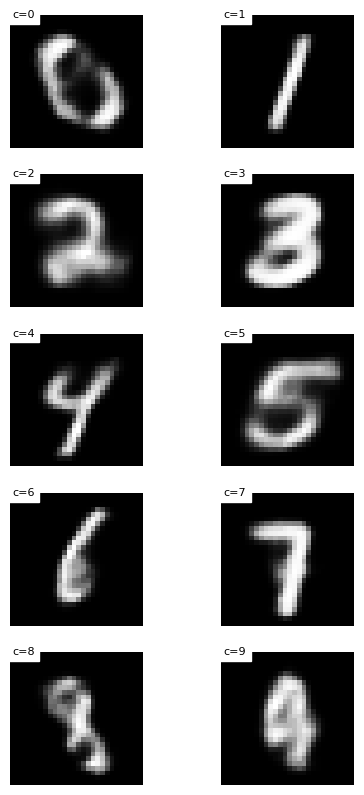

In [ ]:
# TODO

# 6. Clustering the VAE Latent Space[10 pt]

This function analyzes the structure of the **latent space** in a Variational Autoencoder (VAE) by applying **K-Means clustering** and visualizing the results.

Extract the latent space of test dataset. Use KMeans to cluster this space and plot it in 2d space.

Plot one image from each cluster to see if they really represent labels from real dataset.

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import torch


test_loader = DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor(), download=True),
    batch_size=64, shuffle=False
)


def cluster_latent_space(vae_model, dataloader, n_clusters, device):
    vae_model.eval()
    latents = []
    labels = []

    # Iterate through images
    with torch.no_grad():
        for img, label in dataloader:
            img = img.to(device).view(img.size(0), -1)

            # Encode images
            # TODO: Pass image through encoder to get mu (mean)
            # Hint: accessing vae_model.encoder(img) might return a tuple or a single tensor
            latents.append(mu.cpu())
            labels.append(label)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    # Cluster
    # TODO: Initialize and fit KMeans
    kmeans = # TODO
    clusters = # TODO

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    sns.scatterplot(x=latents[:,0], y=latents[:,1], hue=labels, palette='tab10', ax=ax1)
    ax1.set_title('True Classes')
    sns.scatterplot(x=latents[:,0], y=latents[:,1], hue=clusters, palette='tab10', ax=ax2)
    ax2.set_title('Discovered Clusters')
    plt.show()
    return kmeans

# Usage
# kmeans = cluster_latent_space(vae_model, test_loader, 10, device)

This code extends the **Variational Autoencoder (VAE)** by adding a **classification head**. This allows the model to **predict class labels** from the latent space.

Add a linear layer that gets encoding of image as input and outputs the image's label. Change the forward function to also returns class logits. You can also add a classify function to returns just the class logits.

In [ ]:
class VAEWithClassifier(VAE):
    def __init__(self, nz, num_classes):
        super().__init__(nz)
        # Add a classification head
        self.classifier = # TODO

    def forward(self, x):
        # Get the encoded, decoded, mu, and log_var from the VAE
        # Tip: Your parent class forward() returns a dict {'q': ..., 'rec': ...}
        # TODO

        # Pass the latent variable (mu) through the classifier
        class_logits = # TODO
        return class_logits

Load the pretrained vae weights, then use CrossEntropyLoss to train the model for a few epochs.

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
mnist_test = DataLoader(test_dataset, batch_size=64, shuffle=False)
def fine_tune_vae(pretrained_vae, train_loader, test_loader, num_classes, num_epochs=4, learning_rate=1e-3, device=device):
    # Add the classification head to the VAE
    # We assume 'nz' is 32 as per the notebook default
    model = VAEWithClassifier(nz=32, num_classes=num_classes).to(device)

    # Load the pre-trained VAE weights
    # TODO: Load state_dict from pretrained_vae to model (use strict=False to ignore classifier)

    # Define the loss function and optimizer
    criterion = # TODO
    optimizer = # TODO

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device).view(data.shape[0], -1), labels.to(device)

            # Zero the parameter gradients
            # TODO

            # Forward pass
            # TODO

            # Compute the loss
            loss = # TODO

            # Backward pass and optimize
            # TODO

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    return model


num_classes = 10
# Ensure 'VAE' here refers to your trained instance
fine_tuned_model = fine_tune_vae(VAE, mnist_data_loader, mnist_test, num_classes)

Evaluate fine tuned model on test data.

In [ ]:
fine_tuned_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, labels in mnist_test: # Using mnist_test (standard DataLoader in your NB)
        data, labels = data.to(device).view(data.shape[0], -1), labels.to(device)
        # TODO

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")